In [8]:
import os
import sys
import glob

import librosa
import librosa.display

sys.path.append(os.path.dirname(os.path.abspath(f'{os.getcwd()}/AudioCLIP/audioclip')))
from AudioCLIP.audioclip.model import AudioCLIP

import numpy as np

import torch

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}'))

from AudioCLIP.audioclip.utils.transforms import ToTensor1D


torch.set_grad_enabled(False)

MODEL_FILENAME = 'AudioCLIP-Partial-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 3000
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

LABELS = ['cat', 'thunderstorm', 'coughing', 'alarm clock', 'car horn']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
aclp = AudioCLIP(pretrained=f'./pretrained/AudioCLIP/{MODEL_FILENAME}').to(device)

In [10]:
audio_transforms = ToTensor1D()

In [12]:
paths_to_audio = glob.glob('data/thumos/i3d_features/*.wav')[:5]

audio = list()
for path_to_audio in paths_to_audio:
    print("Processing audio: {}".format(path_to_audio))
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)).to(device))
    spec = np.ascontiguousarray(spec.cpu().numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()
    # pow_spec = np.abs(spec).squeeze()
    print(pow_spec.shape)

    audio.append((track, pow_spec))

Processing audio: data/thumos/i3d_features/video_validation_0000721.wav
(1025, 1241)
Processing audio: data/thumos/i3d_features/video_validation_0000332.wav
(1025, 707)
Processing audio: data/thumos/i3d_features/video_validation_0000317.wav
(1025, 1144)
Processing audio: data/thumos/i3d_features/video_test_0001402.wav
(1025, 774)
Processing audio: data/thumos/i3d_features/video_validation_0000912.wav
(1025, 639)


Processing 1/5
Processing 2/5
Processing 3/5
Processing 4/5
Processing 5/5


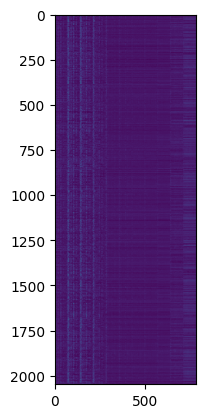

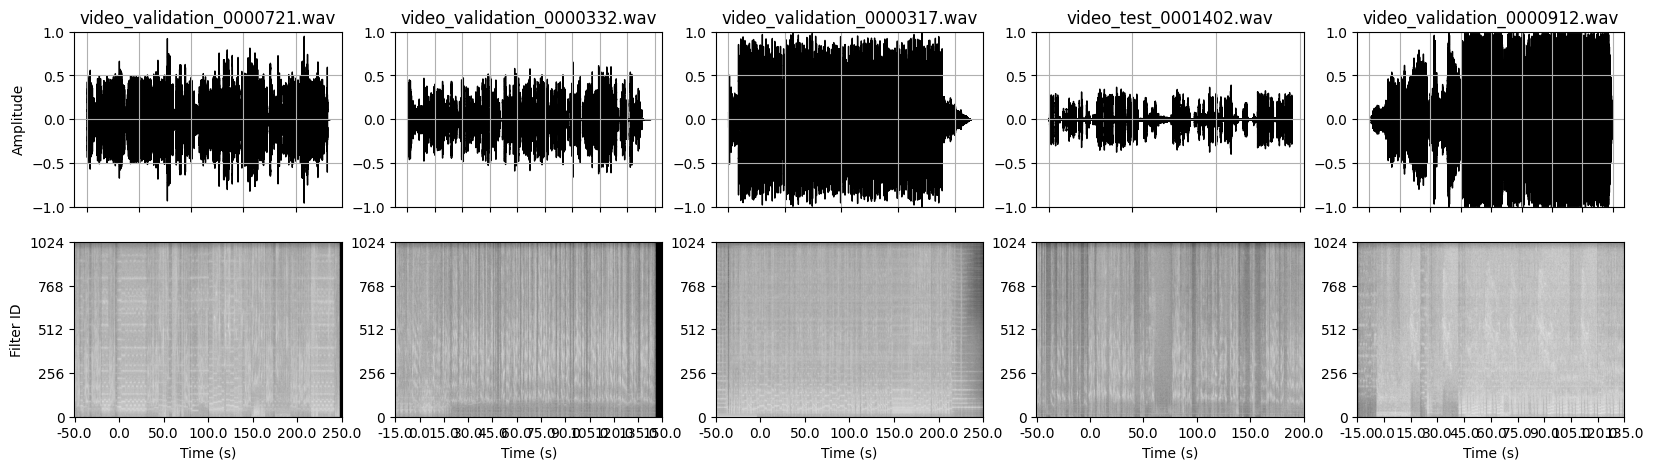

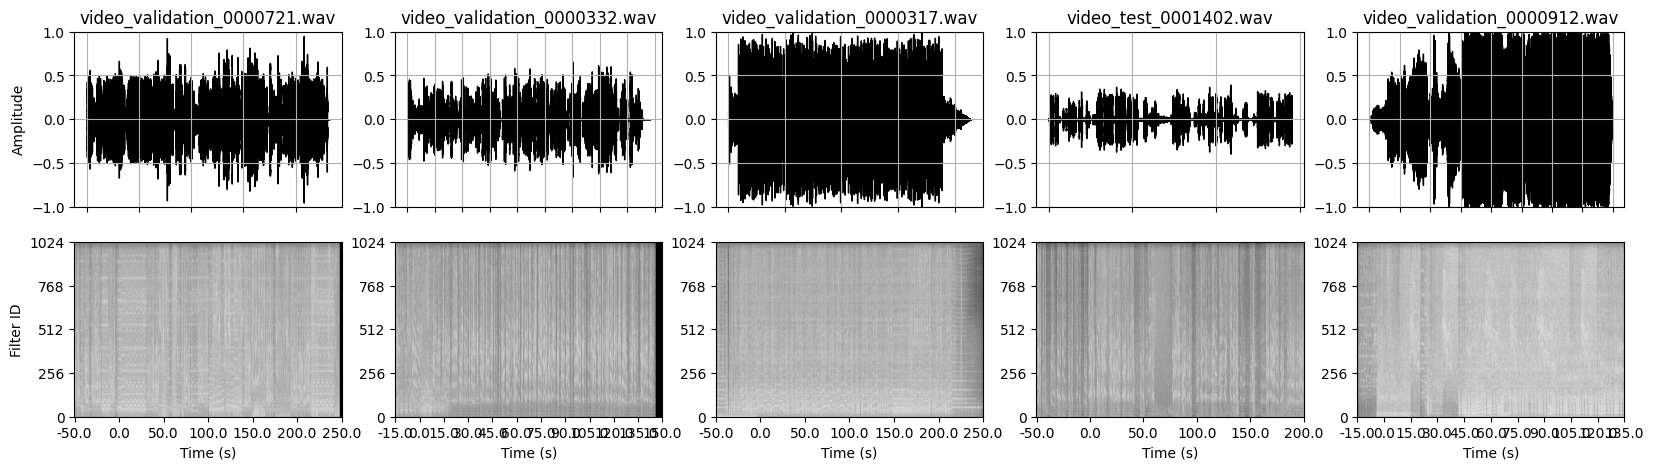

AttributeError: module 'matplotlib' has no attribute 'pyplot'

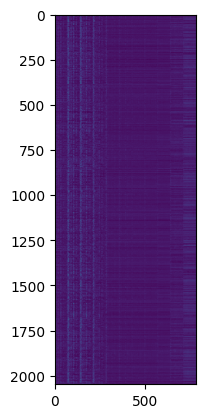

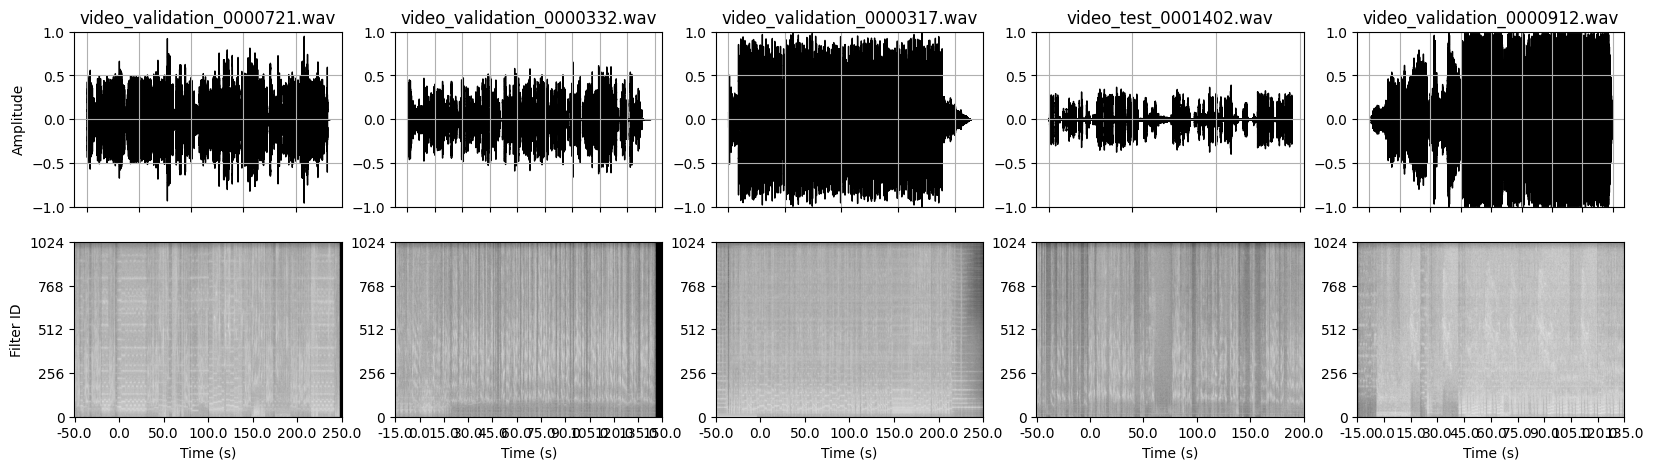

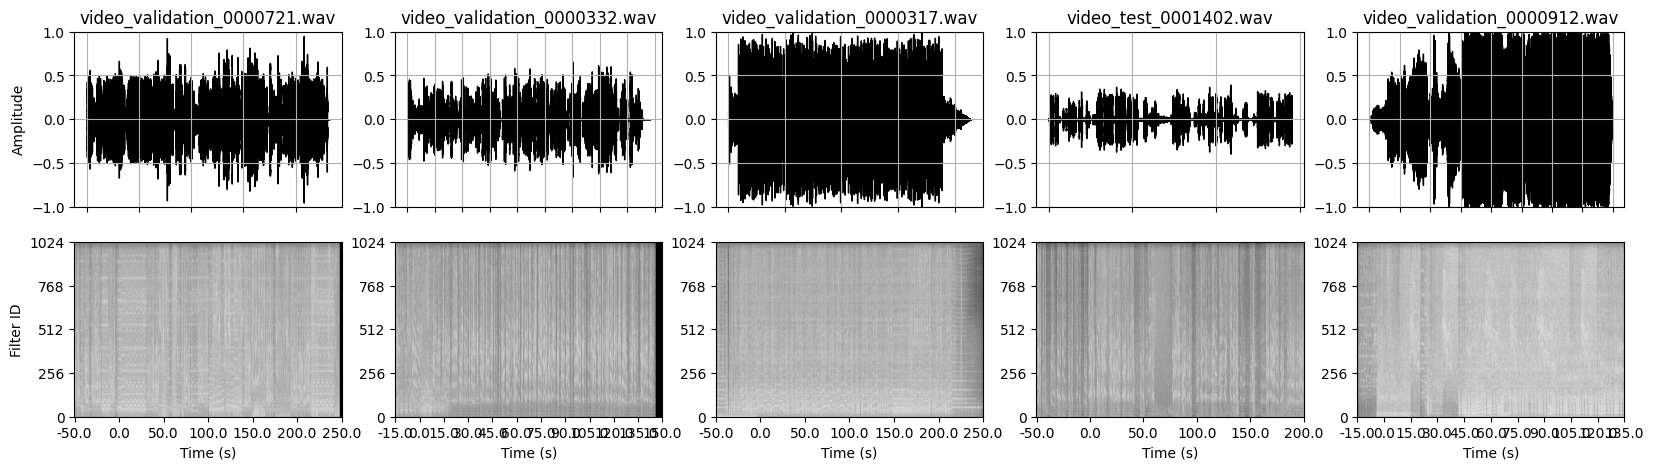

AttributeError: module 'matplotlib' has no attribute 'pyplot'

: 

In [13]:
def show_data():
    fig, axes = plt.subplots(2, len(audio), figsize=(20, 5), dpi=100)

    for idx in range(len(audio)):
        print(f'Processing {idx + 1}/{len(audio)}')
        track, pow_spec = audio[idx]

        # draw the waveform
        librosa.display.waveshow(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
        # show the corresponding power spectrogram
        axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

        # modify legend
        axes[0, idx].set_title(os.path.basename(paths_to_audio[idx]))
        axes[0, idx].set_xlabel('')
        axes[0, idx].set_xticklabels([])
        axes[0, idx].grid(True)
        axes[0, idx].set_ylim(bottom=-1, top=1)

        axes[1, idx].set_xlabel('Time (s)')
        axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
        axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
        axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

    axes[0, 0].set_ylabel('Amplitude')
    axes[1, 0].set_ylabel('Filter ID')

    plt.show()
    plt.close(fig)

    for idx, path in enumerate(paths_to_audio):
        print(os.path.basename(path))
        display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))
show_data()

torch.Size([1, 2048, 781])


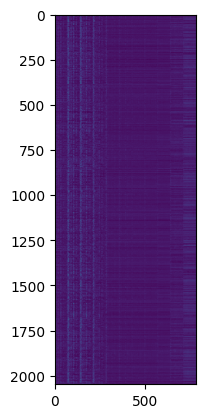

AttributeError: module 'matplotlib' has no attribute 'pyplot'

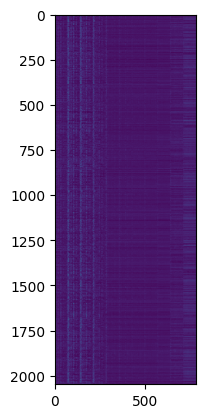

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [6]:
# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
index = 0
for index in range(1):
    audio_ = torch.stack([audio_transforms(track.reshape(1, -1)) for _, track in audio[index:index + 1]])
    ((audio_features, _, _), _), _ = aclp(audio=audio_, only_embedding=True, flatten=True)
    print(audio_features.shape)
plt.imshow(audio_features.detach().cpu().squeeze().numpy())
plt.show()